# Applying DCGAN on CelebA

In [1]:
import numpy as np
import tensorflow as tf
from model import DCGAN
from utils import save_images
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook, we shall train DCGAN on CelebA dataset and visualize the outputs from the generative model. The codes are from https://github.com/carpedm20/DCGAN-tensorflow

## Downloading CelebA dataset

In [2]:
!python download.py celebA

Found Celeb-A - skip


## To train a generative model with the downloaded dataset

In [ ]:
# !python main.py --dataset celebA --input_height=108 --train --crop

## Training generative model (first 2 epochs)

In [4]:
Image(url='./asset/result.gif')

## Visualizing the generative model outputs

In [5]:
# Helpers
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth = True

def dcgan_gen(z_samples):
    tf.reset_default_graph()
    with tf.Session(config=run_config) as sess:
        dcgan = DCGAN(sess, dataset_name="celebA", checkpoint_dir="checkpoint")
        dcgan.load("checkpoint")
        img_samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_samples})
    return img_samples


def img_idx(rid, cid):
    return 8*rid + cid


def visualize_samples(z_samples, savefile='./samples/image_viz.png'):
    if len(z_samples.shape) == 1:
        z_samples = z_samples.reshape(1, len(z_samples))
    assert z_samples.shape[1] == 100
    num = z_samples.shape[0]
    assert num > 0

    if num < 65:
        z_samples2 = np.zeros(shape=(64,100))
        z_samples2[:num] = z_samples
    else:
        num = 64
        z_samples2 = z_samples[:64]
        print('Taking the first 64 samples...')
    
    img_samples = dcgan_gen(z_samples2)
    if num < 9:
        save_images(img_samples[:num], [1, num], savefile)
    else:
        save_images(img_samples[:num], [int(np.ceil(num/8)), 8], savefile)
    display(Image(savefile))


 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


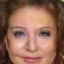

In [6]:
# Average
visualize_samples(np.zeros(shape=(1,100)))

### Generate random samples/Load samples

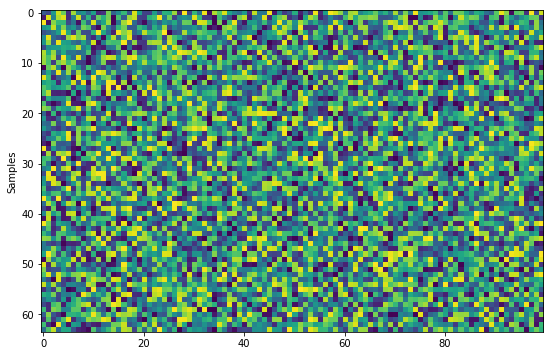

In [7]:
z_samples = np.random.uniform(-1.0, 1.0, size=(64, 100))

fig = plt.figure(figsize = (9,9))
ax1 = fig.add_subplot(111)
ax1.imshow(z_samples)
plt.ylabel('Samples')

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


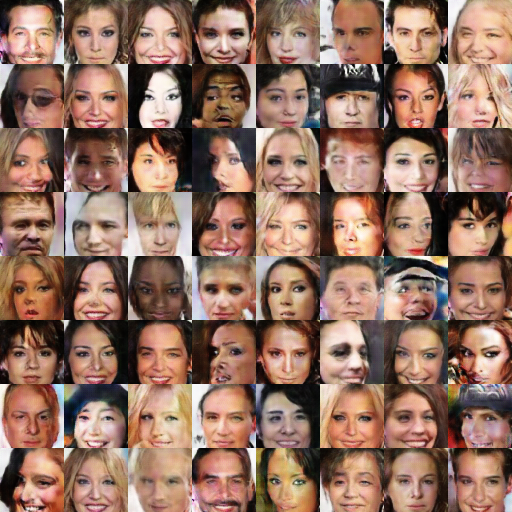

In [8]:
img_samples = dcgan_gen(z_samples)
save_images(img_samples, [8, 8], './samples/image_samples.png')
Image('./samples/image_samples.png')

In [9]:
### Save
# np.savetxt('./samples/z_samples.txt', z_samples)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


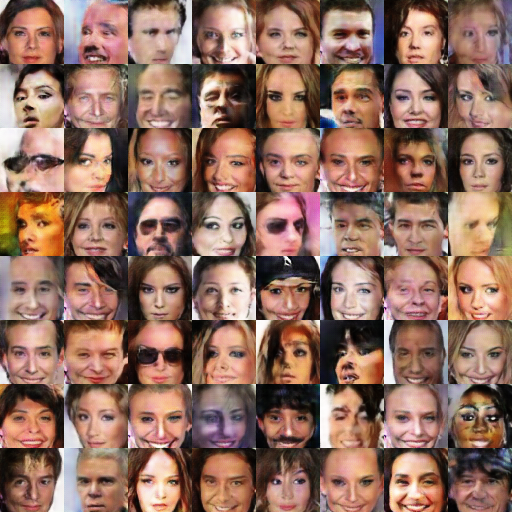

In [10]:
### Load
z_samples = np.loadtxt('./samples/z_samples.txt')

img_samples = dcgan_gen(z_samples)
save_images(img_samples, [8, 8], './samples/image_samples.png')
Image('./samples/image_samples.png')

## Performing face arithmetic with the generative model

## Interpolation

In [11]:
def interpolate_samples(s1, s2, savefile='./samples/image_intrpl.png'):
    z_samples2 = np.zeros(shape=(64, 100))
    z_samples2[0] = s1
    z_samples2[63] = s2
    for idx in range(1,63):
        z_samples2[idx] = float(idx / 63.0) * (z_samples2[63] - z_samples2[0]) + z_samples2[0]
        
    img_samples = dcgan_gen(z_samples2)
    save_images(img_samples[::4], [1, 16], savefile)
    display(Image(savefile))

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


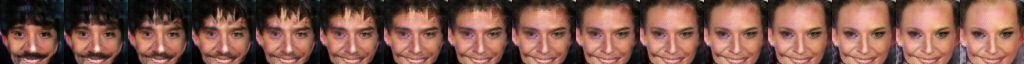

In [12]:
interpolate_samples(z_samples[img_idx(6,4)], z_samples[img_idx(7,5)])

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


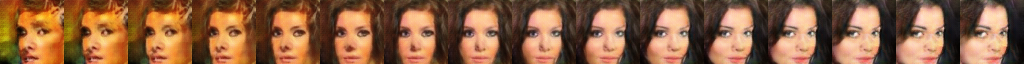

In [13]:
interpolate_samples(z_samples[img_idx(3,0)], z_samples[img_idx(2,1)])

## Face arithmetic: analogies
Man with sunglasses - Man + Woman = Woman with sunglasses

In [14]:
def arithmetic_samples(z0, z1, z2,
                       savefile_mean='./samples/image_mean.png', 
                       savefile_arith='./samples/image_arith.png'):
    z_samples2 = np.zeros(shape=(64, 100))
    z_samples2[0:3] = z0
    z_samples2[3] = np.mean(z0, 0)
    z_samples2[4:7] = z1
    z_samples2[7] = np.mean(z1, 0)
    z_samples2[8:11] = z2
    z_samples2[11] = np.mean(z2, 0)
    rst_vector = np.mean(z0, 0) - np.mean(z1, 0) + np.mean(z2, 0)
    z_samples2[12] = rst_vector
    for idx in range(13,64):
        z_samples2[idx] = rst_vector + 0.25 * np.random.uniform(-1.0, 1.0, 100)

    img_samples = dcgan_gen(z_samples2)
    save_images(img_samples[np.arange(0,12)], [3,4], savefile_mean)
    save_images(img_samples[np.arange(12,37)], [5,5], savefile_arith)
    display(Image(savefile_mean))
    display(Image(savefile_arith))

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


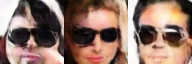

In [15]:
z_sunglasses = np.loadtxt('./samples/z_sunglasses.txt')
visualize_samples(z_sunglasses)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


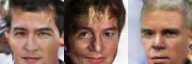

In [20]:
z1= z_samples[[img_idx(3,6), img_idx(7,0), img_idx(7,1)]]
visualize_samples(z1)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


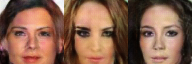

In [21]:
z2 = z_samples[[img_idx(0,0), img_idx(1,4), img_idx(2,7)]]
visualize_samples(z2)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/celebA_64_64_64/DCGAN.model-79002
 [*] Success to read DCGAN.model-79002


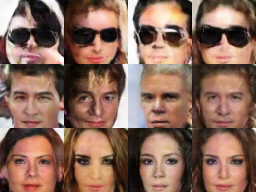

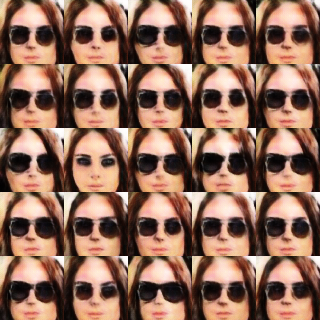

In [22]:
arithmetic_samples(z_sunglasses, z1, z2)